# Usher trees and metadata

This notebook explores data available [from the usher team](http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/). Before running this notebook, run
```sh
scripts/pull_usher.sh  # takes <1 minute
```

In [6]:
import os
import re
import datetime
import pickle
from collections import Counter, defaultdict
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from pyrocov.mutrans import START_DATE
from pyrocov.usher import load_proto

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["figure.facecolor"] = "white"

In [103]:
# Copied from scripts/preprocess_usher.py
DATE_FORMATS = {7: "%Y-%m", 10: "%Y-%m-%d"}

def try_parse_date(string):
    fmt = DATE_FORMATS.get(len(string))
    if fmt is not None:
        return datetime.datetime.strptime(string, fmt)

In [2]:
df = pd.read_csv("results/usher/metadata.tsv", sep="\t", dtype=str)
df

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
0,100002|LR824035.1|2020-03-05,LR824035.1,2020-03-05,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
1,100003|LR824038.1|2020-03-04,LR824038.1,2020-03-04,Switzerland,Homo sapiens,NaN,29903,20B,B.1.1,20B,B.1.1
2,100004|LR824040.1|2020-03-06,LR824040.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
3,100005|LR824037.1|2020-03-06,LR824037.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
4,100006|LR824041.1|2020-03-06,LR824041.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
...,...,...,...,...,...,...,...,...,...,...,...
3578535,tiger/USA/Tiger3-VA/2021|MZ305031.1|2021-04-13,MZ305031.1,2021-04-13,USA,Panthera tigris,NaN,29712,"20I (Alpha, V1)",B.1.1.7,"20I (Alpha,V1)",B.1.1.7
3578536,tiger/USA/tiger-2-040420/2020|MT704313.1|2020-...,MT704313.1,2020-04-04,USA,Panthera tigris,NaN,29872,20C,B.1,20C,B.1
3578537,tiger/USA/tiger-3-040420/2020|MT704315.1|2020-...,MT704315.1,2020-04-04,USA,Panthera tigris,NaN,29863,20C,B.1,20C,B.1
3578538,tiger/USA/tiger-4-040420/2020|MT704316.1|2020-...,MT704316.1,2020-04-04,USA,Panthera tigris,NaN,29834,20C,B.1,20C,B.1


In [109]:
by_date = sorted(
    (d, p)
    for (d, p) in zip(df["date"], df["pangolin_lineage"])
    if isinstance(d, str) and isinstance(p, str)
    if len(d) > 4
    if p not in ["A", "B", "A.1", "B.1"]
)
by_date[:10]

[('2020-01', 'B.42'),
 ('2020-01-05', 'B.1.375'),
 ('2020-01-07', 'B.1.2'),
 ('2020-01-14', 'B.1.1.7'),
 ('2020-01-20', 'B.1.2'),
 ('2020-01-20', 'B.1.258'),
 ('2020-01-21', 'B.1.2'),
 ('2020-01-23', 'A.6'),
 ('2020-01-24', 'B.4'),
 ('2020-01-24', 'B.4')]

In [3]:
df2 = pd.read_csv("results/nextstrain/metadata.tsv", sep="\t", dtype=str)
df2

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_rare_mutations,QC_snp_clusters,QC_frame_shifts,QC_stop_codons,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,good,good,NaN,NaN,NaN,NaN,23584:CAGACT,"T1947C,C3037T,C3587T,C3927T,A8081C,C14408T,G15...","ORF1a:V561A,ORF1a:H1108Y,ORF1a:S1221L,ORF1a:M2...",?
1,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,NaN,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
2,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,NaN,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",5.0
3,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,NaN,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",2.0
4,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,NaN,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3426771,mink/USA/WI-CDC-3892924-001/2020,ncov,?,MW626382,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,ORF6:23-62,NaN,ORF6:23-62,"27267-27268,29816-29821",NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3426772,mink/USA/WI-CDC-3892928-001/2020,ncov,EPI_ISL_1014952,MW626383,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,NaN,NaN,NaN,29816-29821,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3426773,mink/USA/WI-CDC-3892938-001/2020,ncov,EPI_ISL_1014953,MW626384,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,NaN,NaN,NaN,29816-29821,NaN,"C241T,C1059T,C2675T,C3037T,A5877G,A10875G,T119...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:P804S,ORF1a:...",1.0
3426774,mouse/CHN/MP7/2021,ncov,?,OM062573,NaN,2021-05-01,Asia,China,Beijing,NaN,...,good,good,NaN,NaN,NaN,"11288-11296,22283-22291",NaN,"T3C,G174T,C241T,C1059T,A2692T,C3037T,C3817T,C3...","E:T30I,E:P71L,N:T205I,ORF1a:T265I,ORF1a:P1220L...",0.0


In [4]:
df2.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'QC_missing_data', 'QC_mixed_sites', 'QC_rare_mutations',
       'QC_snp_clusters', 'QC_frame_shifts', 'QC_stop_codons', 'frame_shifts',
       'deletions', 'insertions', 'substitutions', 'aaSubstitutions',
       'clock_deviation'],
      dtype='object')

In [5]:
l = df["genbank_accession"].tolist()
print(repr(l[:8]))

['LR824035.1', 'LR824038.1', 'LR824040.1', 'LR824037.1', 'LR824041.1', 'LR824039.1', 'LR824042.1', 'LR824046.1']


In [6]:
ids1 = set(df["genbank_accession"].tolist())

In [7]:
ids2 = set(df2["genbank_accession"].tolist())

In [8]:
print(len(ids1), len(ids2))
print(len(ids1 & ids2), len(ids1 - ids2), len(ids2 - ids1))

2977058 3426776
0 2977058 3426776


In [9]:
ids12 = {i.split(".")[0] for i in ids1 if isinstance(i, str)}
print(len(ids12 & ids2), len(ids12 - ids2), len(ids2 - ids12))

2923819 53154 502957


In [10]:
ids21 = {i + ".1" for i in ids2}
print(len(ids1 & ids21), len(ids1 - ids21), len(ids21 - ids1))

2919731 57327 507045


In [11]:
Counter(i.split(".", 1)[1] for i in ids1 if isinstance(i, str))

Counter({'1': 2972885, '2': 4054, '3': 107, '4': 11})

In [12]:
versions = defaultdict(set)
for i in ids1:
    if isinstance(i, str):
        lhs, rhs = i.split(".")
        versions[lhs].add(rhs)
Counter(map(len, versions.values()))

Counter({1: 2976889, 2: 84})

In [13]:
dates = df2["date"].tolist()
Counter(map(len, dates))

Counter({1: 711, 10: 3395347, 4: 22172, 7: 8546})

In [46]:
start_date = try_parse_date(START_DATE)
days = Counter()
for string in dates:
    date = try_parse_date(string)
    if date is not None:
        days[(date - start_date).days] += 1

In [48]:
with open("results/stats.pkl", "rb") as f:
    stats = pickle.load(f)

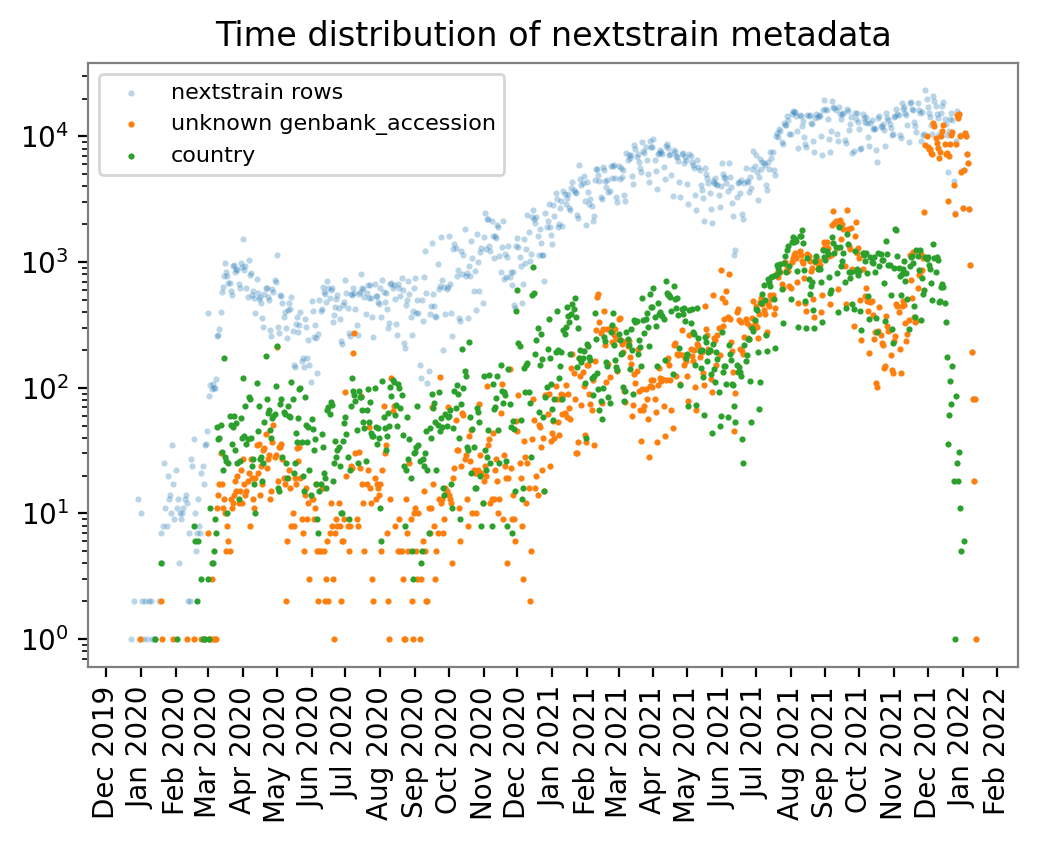

In [50]:
plt.figure(figsize=(6, 4))

# Plot nextstrain samples
start = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
step = datetime.timedelta(days=1)
X = [start + step * x for x in list(days)]
Y = list(days.values())
plt.scatter(X, Y, s=5, lw=0, alpha=0.3, label="nextstrain rows")

# Plot skipped rows.
XYs = {}
for (reason, x), y in stats["skipped_by_day"].items():
    X, Y = XYs.setdefault(reason, ([], []))
    X.append(start + step * x)
    Y.append(y)
for reason, (X, Y) in XYs.items():
    plt.scatter(X, Y, s=5, lw=0, label=reason)
    
plt.yscale("log")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
plt.xticks(rotation=90)
plt.legend(loc="best", fontsize=8)
plt.title("Time distribution of nextstrain metadata");

In [57]:
numer = Counter()
denom = Counter()
orphan = Counter()
for row in tqdm.tqdm(df.itertuples(), total=len(df)):
    if not isinstance(row.date, str):
        continue
    day = try_parse_date(row.date)
    if day is None:
        continue
    denom[day] += 1
    if isinstance(row.genbank_accession, str) and row.genbank_accession:
        numer[day] += 1
    elif 
ratio = {k: numer[k] / v for k, v in denom.items()}

100%|██████████████████████████████████████████████| 3578540/3578540 [00:56<00:00, 63397.79it/s]


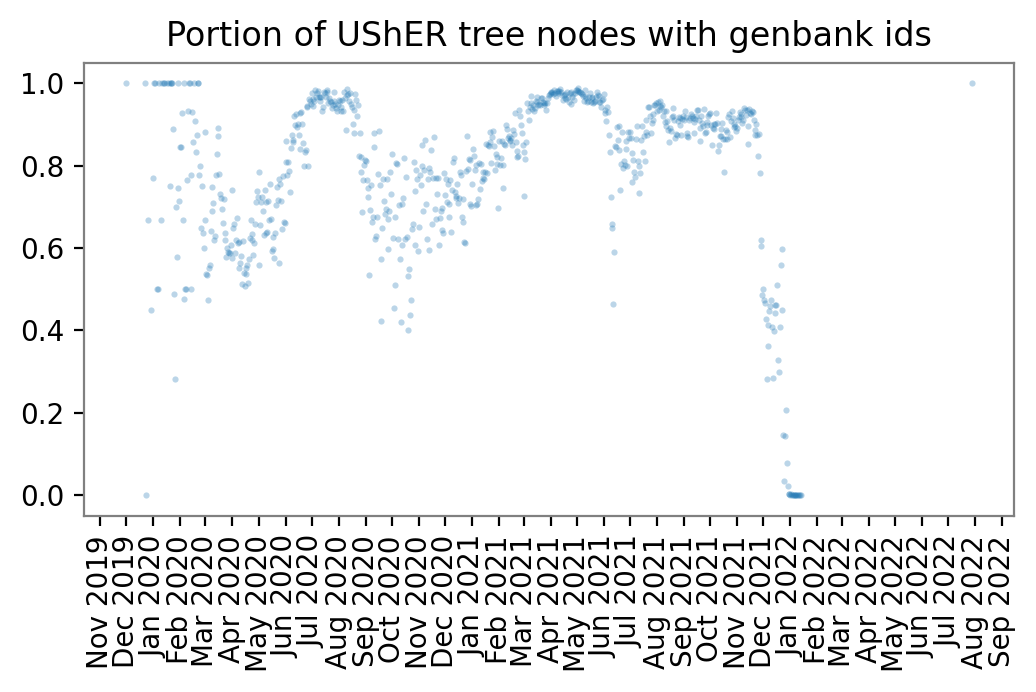

In [63]:
plt.figure(figsize=(6, 3))
plt.scatter(list(ratio), list(ratio.values()), s=5, lw=0, alpha=0.3)    
#plt.yscale("log")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
plt.xticks(rotation=90)
plt.title("Portion of UShER tree nodes with genbank ids");

In [68]:
orphans = df[df.isnull()["genbank_accession"]]
orphans

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
22467,CHN/Beijing_BJ0613-09-Y/2020|GWHANPB01000001|2...,NaN,2020-06-12,China,Homo sapiens,Complete,29848,20B,B.1.1,20B,B.1.1
22468,CHN/Beijing_BJ0613-12-HJ/2020|GWHANPA01000001|...,NaN,2020-06-12,China,Environment,Complete,29858,20B,B.1.1,20B,B.1.1
22469,CHN/Beijing_BJ0617-01-Y/2020|GWHANPC01000001|2...,NaN,2020-06-14,China,Homo sapiens,Complete,29903,20B,B.1.1,20B,B.1.1
22470,CHN/Beijing_IME-BJ01/2020|GWHACAX01000001|2020...,NaN,2020-01-24,China,Homo sapiens,Complete,29872,19B,A,19B,A
22472,CHN/Beijing_IME-BJ02/2020|GWHACAY01000001|2020...,NaN,2020-01-25,China,Homo sapiens,Complete,29828,19B,A,19B,A
...,...,...,...,...,...,...,...,...,...,...,...
3574778,Wuhan_YB012504/human/2020/CHN|GWHACDJ01000001|...,NaN,2020-01-25,China,Homo sapiens,Complete,29865,19A,B,19A,B
3574779,Wuhan_YB012506/human/2020/CHN|GWHACDI01000001|...,NaN,2020-01-25,China,Homo sapiens,Complete,29866,19A,B,19A,B
3574780,Wuhan_YB012602/human/2020/CHN|GWHACDH01000001|...,NaN,2020-01-26,China,Homo sapiens,Complete,29864,19A,B,19A,B
3574781,Wuhan_YB012605/human/2020/CHN|GWHACDG01000001|...,NaN,2020-01-26,China,Homo sapiens,Complete,29861,19A,B,19A,B


In [73]:
orphans.sort_values(by="date", ascending=False)

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
824632,England/MILK-31CD90A/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1036003,England/PHEC-YYB54JH/2022|2022-01-12,NaN,2022-01-12,England,NaN,NaN,NaN,21J (Delta),AY.4,21J (Delta),AY.4
1036119,England/PHEC-YYB5HS9/2022|2022-01-12,NaN,2022-01-12,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1036051,England/PHEC-YYB5AX1/2022|2022-01-12,NaN,2022-01-12,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1036053,England/PHEC-YYB5AZB/2022|2022-01-12,NaN,2022-01-12,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1.1
...,...,...,...,...,...,...,...,...,...,...,...
1039485,England/PHEC-YYBHFSW/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1067504,England/PHEP-YYDKEHE/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1290679,England/QEUH-30A06E9/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1293079,England/QEUH-3175901/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1


In [84]:
ids = orphans["strain"].tolist()

In [89]:
import re
Counter(re.split(r"[/|_]", x)[0] for x in ids).most_common()

[('England', 388437),
 ('Wales', 128073),
 ('Scotland', 38889),
 ('Northern', 38033),
 ('NorthernIreland', 3378),
 ('Guangzhou', 147),
 ('Wuhan', 63),
 ('Weifang', 20),
 ('CHN', 11),
 ('Fuyang', 1),
 ('Gilgit1', 1),
 ('Hangzhou', 1),
 ('ICDC-DT005', 1),
 ('WH01', 1),
 ('WH03', 1),
 ('WH04', 1),
 ('WIV02', 1),
 ('WIV04', 1),
 ('WIV05', 1),
 ('WIV06', 1),
 ('WIV07', 1)]

In [90]:
Counter(orphans["country"]).most_common()

[('England', 388437),
 ('Wales', 128073),
 ('Northern Ireland', 41411),
 ('Scotland', 38889),
 ('China', 252),
 ('Pakistan', 1)]

In [92]:
from pyrocov.geo import get_canonical_location_generator
get_canonical_location = get_canonical_location_generator()
locations = Counter()
for row in tqdm.tqdm(df2.itertuples(), total=len(df2)):
    location = get_canonical_location(
        row.strain, row.region, row.country, row.division, row.location
    )
    locations[location] += 1

100%|██████████████████████████████████████████████| 3426776/3426776 [00:48<00:00, 70675.68it/s]


In [93]:
locations.most_common()

[('Europe / United Kingdom / England', 1133176),
 ('North America / USA / CA', 277056),
 ('North America / USA / CO', 134531),
 ('Europe / United Kingdom / Scotland', 129262),
 ('North America / USA / FL', 112424),
 ('North America / USA / MA', 108507),
 ('Europe / Switzerland', 99145),
 ('North America / USA / MN', 96434),
 ('North America / USA / TX', 82572),
 ('Europe / Germany / North Rhine Westphalia', 73558),
 ('North America / USA / WA', 57171),
 ('North America / USA / MI', 55347),
 ('North America / USA / UT', 49931),
 ('Europe / Germany / Baden-Wuerttemberg', 44918),
 ('North America / USA / NJ', 44165),
 ('North America / USA / NC', 43909),
 ('North America / USA / PA', 43263),
 ('North America / USA / NY', 40567),
 ('North America / USA / GA', 39344),
 ('North America / USA / AZ', 37980),
 ('North America / USA / IL', 34693),
 ('Europe / Germany / Bavaria', 31001),
 ('North America / USA / OH', 28252),
 ('North America / USA / VA', 27235),
 ('North America / USA / TN', 2716

## Comparison with the usher tree

In [17]:
from pyrocov.external.usher import parsimony_pb2
from Bio.Phylo.NewickIO import Parser, Writer

with open("results/usher/all.masked.pb", "rb") as f:
    proto = parsimony_pb2.data.FromString(f.read())
tree = next(Parser.from_string(proto.newick).parse())

In [18]:
dir(proto)

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_by_number',
 'condensed_nodes',
 'metadata',
 'newick',
 'node_mutations']

In [19]:
print(len(proto.condensed_nodes))
print(proto.condensed_nodes[:10])

440362
[node_name: "node_381273_condensed_3_leaves"
condensed_leaves: "England/BRBR-2AC04F1/2021|OV155469.1|2021-11-15"
condensed_leaves: "England/ALDP-2BC8531/2021|OV257737.1|2021-11-23"
condensed_leaves: "England/MILK-2D0EFB7/2021|2021-12-02"
, node_name: "node_361704_condensed_4_leaves"
condensed_leaves: "USA/CO-CDPHE-2102178438/2021|OL963152.1|2021-11-07"
condensed_leaves: "USA/CO-CDC-MMB11531268/2021|OL778480.1|2021-11-09"
condensed_leaves: "USA/CO-CDPHE-2102305101/2021|OL930945.1|2021-11-22"
condensed_leaves: "USA/CO-CDPHE-2102368595/2021|OM004977.1|2021-11-28"
, node_name: "node_202893_condensed_5_leaves"
condensed_leaves: "England/MILK-1C5249B/2021|OU603415.1|2021-08-19"
condensed_leaves: "England/ALDP-1D07142/2021|OU641091.1|2021-08-26"
condensed_leaves: "England/MILK-1D29D46/2021|OU683756.1|2021-08-31"
condensed_leaves: "England/MILK-1D317B6/2021|OU682397.1|2021-08-31"
condensed_leaves: "England/MILK-1DF25C6/2021|OU707938.1|2021-09-08"
, node_name: "node_338076_condensed_2_le

In [20]:
strains = set(df2["strain"])

In [21]:
"Switzerland/LU-DIA-011424153001/2021|OU755170.1|2021-09-01" in strains

False

In [22]:
"Switzerland/LU-DIA-011424153001/2021" in strains

True

In [23]:
Counter(bool(node.name) for node in tree.find_clades())

Counter({False: 747078, True: 1679768})

## Phylogenetic distribution of samples in pruned trees

In [94]:
%%time
with open(f"results/columns.pkl", "rb") as f:
    columns = pickle.load(f)
clade_counts = {}
for max_num_clades in [2000, 3000, 5000, 10000]:
    filename = f"results/columns.{max_num_clades}.pkl"
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            counts = Counter(pickle.load(f)["clade"])
            clade_counts[max_num_clades] = counts
            print((max_num_clades, len(counts)))

(2000, 1991)
(3000, 2991)
(5000, 4988)
(10000, 9977)
CPU times: user 8.27 s, sys: 5.14 s, total: 13.4 s
Wall time: 16.8 s


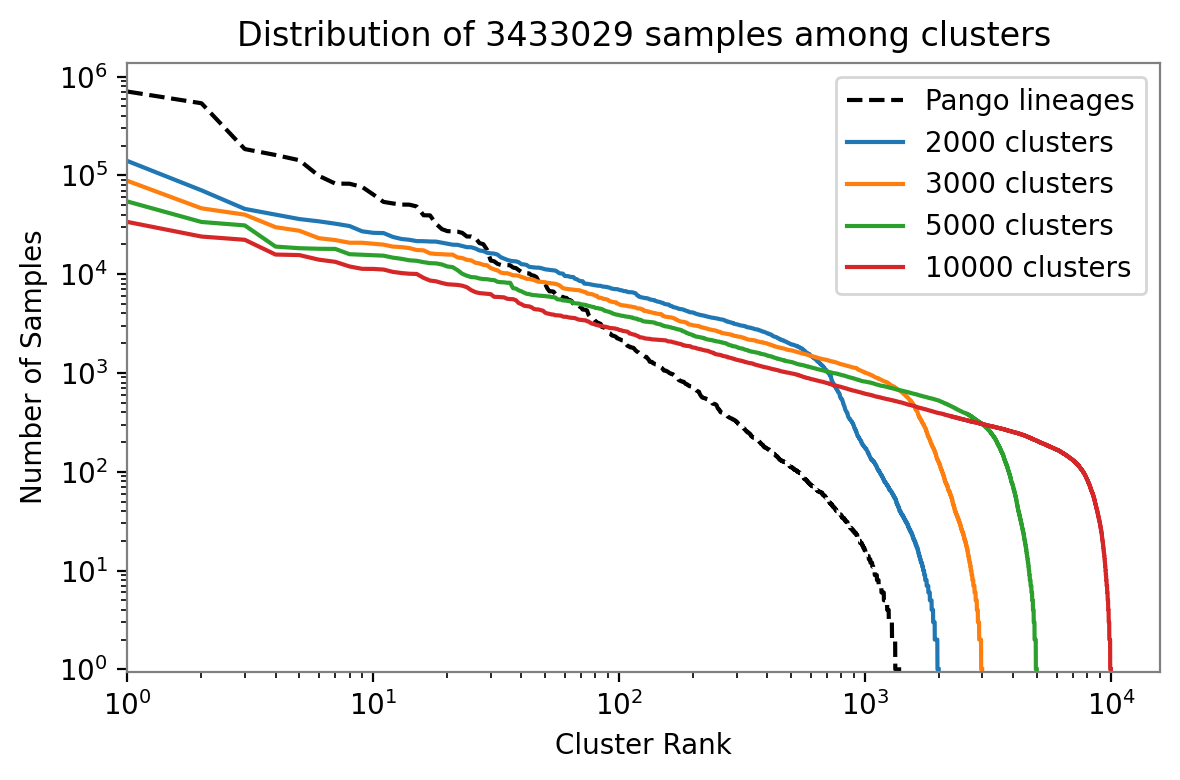

In [96]:
strain_counts = Counter(columns["lineage"])
plt.figure(figsize=(6,4))
Y = [c for _, c in strain_counts.most_common()]
plt.plot(torch.arange(1,1 + len(Y)), Y, "k--", label="Pango lineages")
for k, v in clade_counts.items():
    Y = [c for _, c in v.most_common()]
    plt.plot(torch.arange(1,1 + len(Y)), Y, label=f"{k} clusters")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, None)
plt.ylim(0.95, None)
plt.xlabel("Cluster Rank")
plt.ylabel("Number of Samples")
plt.legend(loc="upper right")
plt.title(f"Distribution of {len(columns['lineage'])} samples among clusters")
plt.tight_layout()
plt.savefig("paper/clade_distribution.png")

In [97]:
print({k: len(v) for k, v in clade_counts.items()})

{2000: 1991, 3000: 2991, 5000: 4988, 10000: 9977}


In [98]:
print({k: len(v) for k, v in columns.items()})

{'clade': 3433029, 'nodename': 3433029, 'genbank_accession': 3433029, 'day': 3433029, 'location': 3433029, 'lineage': 3433029}


In [99]:
columns.keys()

dict_keys(['clade', 'nodename', 'genbank_accession', 'day', 'location', 'lineage'])

In [100]:
columns["day"][:10]

[96, 78, 125, 115, 111, 115, 117, 114, 131, 117]

In [30]:
with open("results/columns.2000.pkl", "rb") as f:
    columns2000 = pickle.load(f)

In [31]:
{k: len(v) for k, v in columns.items()}

{'genbank_accession': 2693776,
 'day': 2693776,
 'location': 2693776,
 'lineage': 2693776,
 'nodename': 2693776,
 'clade': 2693776}

In [32]:
{k: len(v) for k, v in columns2000.items()}

{'genbank_accession': 2693776,
 'day': 2693776,
 'location': 2693776,
 'lineage': 2693776,
 'nodename': 2693776,
 'clade': 2693776}

In [33]:
print(sum(1 for clade in tree.find_clades()))
print(sum(bool(clade.name) for clade in tree.find_clades()))

2426846
1679768


In [34]:
list(proto.condensed_nodes[0].condensed_leaves)

['England/BRBR-2AC04F1/2021|OV155469.1|2021-11-15',
 'England/ALDP-2BC8531/2021|OV257737.1|2021-11-23',
 'England/MILK-2D0EFB7/2021|2021-12-02']

## Exploring a larger tree

In [24]:
%%time
proto, tree = load_proto("results/gisaid/gisaidAndPublic.masked.pb.gz")
print(len(proto.metadata))

4833238
CPU times: user 1min 27s, sys: 21.1 s, total: 1min 49s
Wall time: 2min 2s


In [12]:
condensed_nodes = {}
for node in proto.condensed_nodes:
    condensed_nodes[node.node_name] = list(node.condensed_leaves)
print(len(condensed_nodes))
print(sum(map(len, condensed_nodes.values())))

926211
4792935


In [25]:
strains = set()
gisaids = set()
for node in tqdm.tqdm(tree.find_clades(), total=len(proto.metadata)):
    if node.name:
        for name in condensed_nodes.get(node.name, [node.name]):
            strains.add(name)
            match = re.search(r"\bEPI_ISL_[0-9]+\b", name)
            if match:
                gisaids.add(match.group(0))
print(len(strains), len(gisaids))

100%|██████████████████████████████████████████████| 4833238/4833238 [01:02<00:00, 77444.13it/s]

7140401 3487191
